#  Personal Loan Conversion Optimization

Obj : Leverage on Machine Learning Model for better target marketing, so as to increase success ratio for Personal Loan with minimal budget

## Import necessary modules

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

## Import raw data

In [2]:
df = pd.read_excel('~/Downloads/DS_assessment.xlsx', sheet_name='Data')

# Explorative Data Analysis

In [3]:
df.head()

,ID,Age,Experience,Income,Postal Code,Family Size,CCAvgSpending,Education,Mortgage,Investment Account,Deposit Account,InternetBanking,Personal Loan
0,1,25,1,49.0,91107,4.0,1.6,Undergrad,0,1,0,NO,NO
1,2,45,19,34.0,90089,3.0,1.5,Undergrad,0,1,0,NO,NO
2,3,39,15,11.0,94720,1.0,1.0,Undergrad,0,0,0,NO,NO
3,4,35,9,NaN,94112,1.0,2.7,Graduate,0,0,0,NO,NO
4,5,35,8,45.0,91330,4.0,1.0,Graduate,0,0,0,NO,NO


In [4]:
#Check for duplicated row, 0 denotes no duplication

df.duplicated().sum()

0

In [5]:
#For the categorical columns, print all the unique values

for i in df.select_dtypes(include='object').columns.to_list() :
    print(i)
    print(df[i].unique())
    print('\n')

Education
['Undergrad' 'Graduate' 'Advanced Degree']


InternetBanking
['NO' 'YES']


Personal Loan
['NO' 'YES']




In [6]:
#describe() gives a quick rundown of the descriptive stats for eah column

df.describe()

,ID,Age,Experience,Income,Postal Code,Family Size,CCAvgSpending,Mortgage,Investment Account,Deposit Account
count,5000.000000,5000.000000,5000.000000,4980.000000,5000.000000,4991.000000,5000.000000,5000.000000,5000.000000,5000.00000
mean,2500.500000,45.338400,20.104600,73.840361,93152.503000,2.396714,1.937938,56.498800,0.104400,0.06040
std,1443.520003,11.463166,11.467954,46.079300,2121.852197,1.148189,1.747659,101.713802,0.305809,0.23825
min,1.000000,23.000000,-3.000000,8.000000,9307.000000,1.000000,0.000000,0.000000,0.000000,0.00000
25%,1250.750000,35.000000,10.000000,39.000000,91911.000000,1.000000,0.700000,0.000000,0.000000,0.00000
50%,2500.500000,45.000000,20.000000,64.000000,93437.000000,2.000000,1.500000,0.000000,0.000000,0.00000
75%,3750.250000,55.000000,30.000000,98.000000,94608.000000,3.000000,2.500000,101.000000,0.000000,0.00000
max,5000.000000,67.000000,43.000000,224.000000,96651.000000,4.000000,10.000000,635.000000,1.000000,1.00000


From above, a few interesting points are observed :

1. Data collected <b>Age</b> between 23 to 67
2. <b>Experience</b> includes negative number

In [7]:
#check how many negatives values we have for experience and the value_counts

df[df['Experience']<=0]['Experience'].value_counts()

Experience
 0    66
-1    33
-2    15
-3     4
Name: count, dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              4980 non-null   float64
 4   Postal Code         5000 non-null   int64  
 5   Family Size         4991 non-null   float64
 6   CCAvgSpending       5000 non-null   float64
 7   Education           5000 non-null   object 
 8   Mortgage            5000 non-null   int64  
 9   Investment Account  5000 non-null   int64  
 10  Deposit Account     5000 non-null   int64  
 11  InternetBanking     5000 non-null   object 
 12  Personal Loan       5000 non-null   object 
dtypes: float64(3), int64(7), object(3)
memory usage: 507.9+ KB


info() helps to give a quick view for any null-values in the data, which can be problematic for modelling/analysis subsequently, we will need to decide a strategy to deal with these blank.

<b>Some strategies we can use</b>
1. dropping the null values
2. imputing a values

Since the missing nulls only made up very little numbers of data, I would typically drop these row but for demostration purposes, I will go for the imputing approach.

# Data Cleaning

## impute values for family size and Income here

When imputing missing values, a common mistakes is to impute values based on the overall data. This is not ideal as different classes may have very different descriptive stats. In this example, after check the boxplot of various classes, I've decided to

1. Impute <b>Family Size</b> based on average of different <b>age_bucket</b>
2. Impute <b>Income</b> based on average of different <b>Education level<b>

<Axes: xlabel='Age_bracket', ylabel='Family Size'>

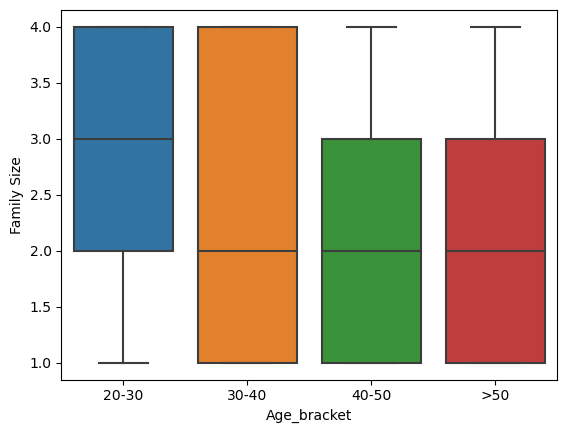

In [9]:
# Define the age brackets and corresponding labels
bins = [20, 30, 40, 50, float('inf')]  # The last bin represents >50
labels = ['20-30', '30-40', '40-50', '>50']

# Create the 'Age_bracket' column
df['Age_bracket'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)
sns.boxplot(df, x='Age_bracket', y='Family Size')

In [10]:
def impute_fs(row):
    family_size = row['Family Size']
    age_bracket = row['Age_bracket']
    
    if pd.isnull(family_size):
        if age_bracket == '20-30':
            return round(df[df['Age_bracket'] == '20-30']['Family Size'].mean())
        else:
            return round(df[df['Age_bracket'] != '20-30']['Family Size'].mean())
    else:
        return family_size

df['Family Size'] = df.apply(impute_fs, axis=1)

<Axes: xlabel='Education', ylabel='Income'>

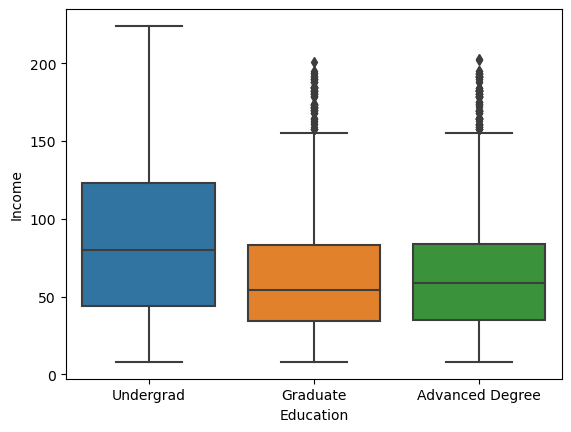

In [11]:
sns.boxplot(df, x='Education', y='Income')

In [12]:
def impute_income(row):
    Income = row['Income']
    Education = row['Education']
    
    if pd.isnull(Income):
        if Education == 'Undergrad':
            return round(df[df['Education'] == 'Undergrad']['Income'].mean())
        else:
            return round(df[df['Education'] != 'Undergrad']['Income'].mean())
    else:
        return Income

df['Income'] = df.apply(impute_income, axis=1)

## negative experience values

Not sure why it's negative so I'm wary of jumping the gun to conclude that this is wrong. Normally, I will investigate reasons for it to be negative but since that's not possible now, I will proceed to drop these row since it made up only ~1% of total data

In [13]:
df = df[df['Experience'] >= 0]

In [14]:
#Check if we still have any null-values
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4948 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   ID                  4948 non-null   int64   
 1   Age                 4948 non-null   int64   
 2   Experience          4948 non-null   int64   
 3   Income              4948 non-null   float64 
 4   Postal Code         4948 non-null   int64   
 5   Family Size         4948 non-null   float64 
 6   CCAvgSpending       4948 non-null   float64 
 7   Education           4948 non-null   object  
 8   Mortgage            4948 non-null   int64   
 9   Investment Account  4948 non-null   int64   
 10  Deposit Account     4948 non-null   int64   
 11  InternetBanking     4948 non-null   object  
 12  Personal Loan       4948 non-null   object  
 13  Age_bracket         4948 non-null   category
dtypes: category(1), float64(3), int64(7), object(3)
memory usage: 546.2+ KB


## Check value counts of target variables 

if values are too little, we may need to use "SMOTE" and "RandomUnderSampler" to increase/decrease the majority/minority class

In [15]:
df['Personal Loan'].value_counts()

Personal Loan
NO     4468
YES     480
Name: count, dtype: int64

"YES" is ~10% of overall data, this might be a little low but let's go ahead to train and measure model accuracy before deciding later if necessary to use "SMOTE" and "RandomUnderSample" later on.

## Prep data for training
Replace 'NO' with 0 and 'YES' with 1 for binary data

In [16]:
df['InternetBanking'] = df['InternetBanking'].replace({'NO': 0, 'YES': 1})
df['Personal Loan'] = df['Personal Loan'].replace({'NO': 0, 'YES': 1})

For non-binary data, we use getdummies to convert them into indicator variables

In [17]:
cat_feat = df.select_dtypes(include='object').columns
df2 = pd.get_dummies(df, columns=cat_feat, drop_first=1).drop('Age_bracket', axis=1)

# Splitting data in 3 sets 
train, test, validation

In [18]:
X = df2.drop(['ID', 'Personal Loan'], axis=1)
y = df2['Personal Loan']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=101)

# Baseline Test
Before we go ahead with training, it's often helpful to conduct a baseline test. This test helps us understand the baseline for our model performance. In this scenario, I have created a model that simply predict 0 for every sample. And this already given us 91% in accuracy. What this tells us is that for our model to be truly effective, we will need accuracy at least higher than 91%

In [19]:
print(classification_report(y_test, np.zeros_like(y_test), zero_division=0))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       904
           1       0.00      0.00      0.00        86

    accuracy                           0.91       990
   macro avg       0.46      0.50      0.48       990
weighted avg       0.83      0.91      0.87       990



# Linear Regression

In [20]:
lm = LogisticRegression(max_iter=1000, random_state=42)

lm.fit(X_train, y_train)
lm_pred = lm.predict(X_test)

print(classification_report(y_test, lm_pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       904
           1       0.42      0.37      0.39        86

    accuracy                           0.90       990
   macro avg       0.68      0.66      0.67       990
weighted avg       0.90      0.90      0.90       990



A Simple Linear Regression yielded accuracy of 90%, which might be accepted as good performance but if we compared it with baseline test, we would quickly grasp that it actually perform worst than a model that simply predict 0 for every sample.

On this point alone, we can quickly decide that this model isn't ideal for our use case. Poor performace in term of   precision and recall for class 1 also supported Linear Regression might not be the most ideal method.

# Decision Tree

In [21]:
dtree = DecisionTreeClassifier(random_state=42)

dtree.fit(X_train, y_train)
dtree_pred = dtree.predict(X_test)

print(classification_report(y_test, dtree_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       904
           1       0.93      0.91      0.92        86

    accuracy                           0.99       990
   macro avg       0.96      0.95      0.95       990
weighted avg       0.99      0.99      0.99       990



This is some very good result but can we do better? Let's try by <b>iterating the model to find ideal max_depth values</b>

,max_depth,test_accuracy
7,8,0.985859


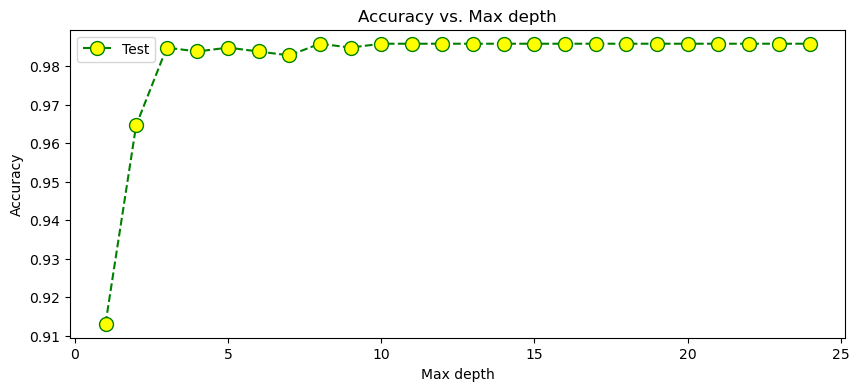

In [22]:
test_accuracy = []

for max_d in range(1,25):
    model = DecisionTreeClassifier(max_depth=max_d, random_state=42)
    model.fit(X_train, y_train)
    test_accuracy.append(model.score(X_test, y_test))
    
plt.figure(figsize=(10, 4))
plt.plot(range(1, 25), test_accuracy, ls='--', marker='o', color='green', markerfacecolor='yellow', markersize=10, label='Test')

plt.title('Accuracy vs. Max depth')
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.legend()


index_range = range(1, 25)

data = {'Index': index_range, 'test_accuracy': test_accuracy}
df_test_accuracy = pd.DataFrame(data).set_index('Index')
df_test_accuracy.index.name = 'max_depth'
df_test_accuracy = df_test_accuracy.reset_index(drop=False)

df_test_accuracy = df_test_accuracy[(df_test_accuracy['test_accuracy']==df_test_accuracy['test_accuracy'].max())]
df_test_accuracy = df_test_accuracy[(df_test_accuracy['max_depth']==df_test_accuracy['max_depth'].min())]

df_test_accuracy

So it looks like we get max accuracy when max_depth=8

In [23]:
dtree = DecisionTreeClassifier(max_depth=8, random_state=42)

dtree.fit(X_train, y_train)
dtree_pred = dtree.predict(X_test)

print(classification_report(y_test, dtree_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       904
           1       0.91      0.93      0.92        86

    accuracy                           0.99       990
   macro avg       0.95      0.96      0.96       990
weighted avg       0.99      0.99      0.99       990



Recall for class 1 are better when we use max_depth=8 while compromising on precision. Consider our objective, I'm inclined toward a higher recall for class 1 so as to ensure we captured as many convert users as possible.

# Check if decision tree model has been overfitted 

Decision tree is quite prone to overfitted, making it losing predictive power when giving brand new data. As a litmus test, we can use 2 methods

## 1. Check performance using the validation set

Remember we splitted our data in 3 sets initially? This is when the third set (validation sets) comes into the pictures

In [24]:
dtree_pred = dtree.predict(X_val)
print(classification_report(y_val, dtree_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       716
           1       0.89      0.88      0.89        76

    accuracy                           0.98       792
   macro avg       0.94      0.94      0.94       792
weighted avg       0.98      0.98      0.98       792



Though recall for class 1 are not as good as as test sets, we can see that most other metrics are still doing quite well. Thus the model doesn't appear to have been overfitted

## 2. Check via k-fold cross-validation

In [25]:
dtree_scores = cross_val_score(dtree, X_train, y_train, scoring='accuracy', cv=10)
dtree_scores

array([0.98107256, 0.98422713, 0.97791798, 0.97791798, 0.98422713,
       0.97160883, 0.97151899, 0.9778481 , 0.98101266, 0.9778481 ])

In [26]:
dtree_scores.mean()

0.9785199456934073

all 10 folds appear somewhat similar, this also support the fact that the model hasn't been overfitted.

# Features importances

Now that we have establish <b>"Decision Tree"</b> to be the model, let's find out what're the main features the model relied on for prediction

In [27]:
dtree_fi = pd.DataFrame(dtree.feature_importances_, X_test.columns, columns=['feature_importance'])
dtree_fi.sort_values(by='feature_importance', ascending=False)

,feature_importance
Education_Undergrad,0.359472
Income,0.346262
Family Size,0.138641
CCAvgSpending,0.068566
Deposit Account,0.027395
Postal Code,0.027176
Age,0.017841
Experience,0.008476
Education_Graduate,0.002827
Mortgage,0.002415


<b>Education_Undergrad</b> and <b>Income</b> appear to be the 2 main features with highest feature importance

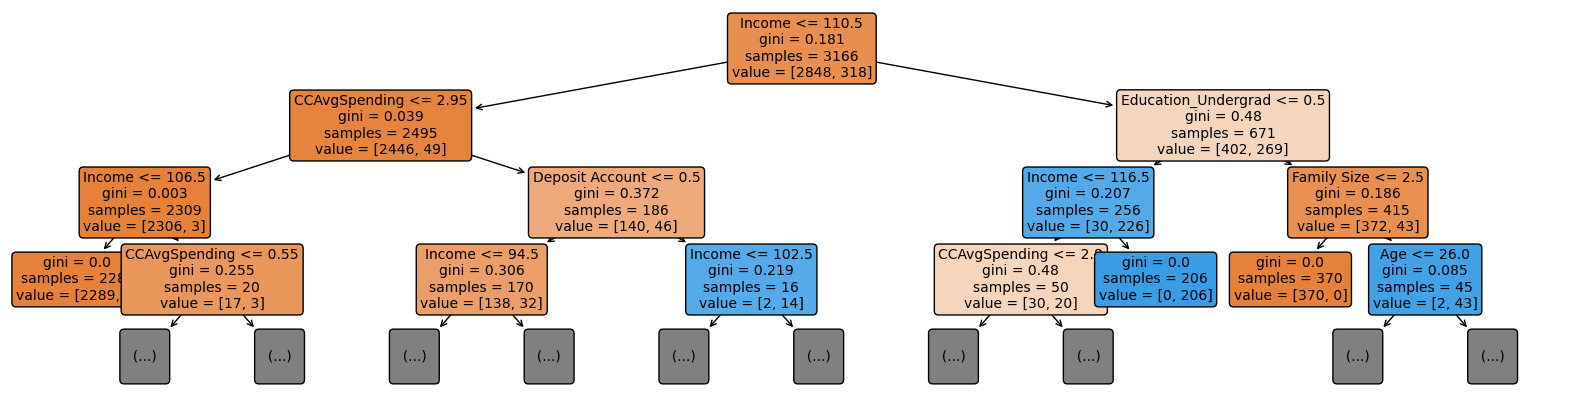

In [28]:
plt.figure(figsize=(20, 5)) 
plot_tree(dtree, feature_names=X.columns, filled=True, rounded=True, fontsize=10,  max_depth=3)
plt.show()

<b>Income : </b> >110k seems to be the most ideal threshold to tells whether an potential would take up personal loan
<br>
<b>Education : </b> Not Undergrad are more likely to take up personal loan

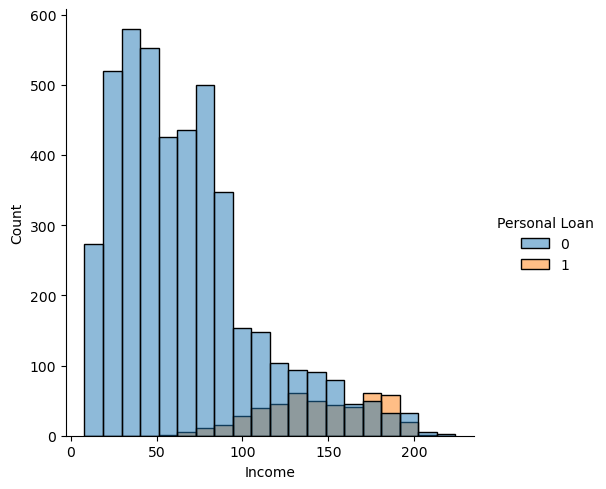

In [29]:
sns.displot(df, x='Income', hue='Personal Loan', bins=20)

Though not a lot, we can see quite a number of borrowers with income between 100~110 also taken up personal loan

In [30]:
loan_total_cnt = df[(df['Personal Loan']==1)].count()[0]
loan_110k_cnt = df[(df['Personal Loan']==1)&(df['Income']>110)].count()[0]
pct = (loan_110k_cnt/loan_total_cnt).round(2)

print(f'{loan_110k_cnt} out of {loan_total_cnt} personal loan borrowers has income 110k or more. ({pct})')

410 out of 480 personal loan borrowers has income 110k or more. (0.85)


In [31]:
loan_total_cnt = df[(df['Personal Loan']==1)].count()[0]
loan_100k_cnt = df[(df['Personal Loan']==1)&(df['Income']>100)].count()[0]
pct = (loan_100k_cnt/loan_total_cnt).round(2)

print(f'{loan_100k_cnt} out of {loan_total_cnt} personal loan borrowers has income 100k or more. ({pct})')

437 out of 480 personal loan borrowers has income 100k or more. (0.91)


In [32]:
more_than_100k = df[df['Income']>100]['Personal Loan'].mean().round(2)
less_or_equal_100k = df[df['Income']<=100]['Personal Loan'].mean().round(2)

print('\033[1m'+'Loan Conversion rates by income'+ '\033[0m' )
print(f'More than 100k : {more_than_100k}')
print(f'Less than or equal 100k : {less_or_equal_100k}')

Loan Conversion rates by income
More than 100k : 0.36
Less than or equal 100k : 0.01


In [33]:
loan_total_cnt = df[(df['Personal Loan']==1)].count()[0]
loan_postgrad_cnt = df[(df['Personal Loan']==1)&(df['Education']!='Undergrad')].count()[0]
pct = (loan_postgrad_cnt/loan_total_cnt).round(2)

print(f'{loan_postgrad_cnt} out of {loan_total_cnt} personal loan borrowers possessed a graduate or higher degree. ({pct})')


387 out of 480 personal loan borrowers possessed a graduate or higher degree. (0.81)


In [34]:
postgrad = df[df['Education']!='Undergrad']['Personal Loan'].mean().round(2)
undergrad = df[df['Education']=='Undergrad']['Personal Loan'].mean().round(2)

print('\033[1m'+'Loan Conversion rates by Education'+ '\033[0m' )
print(f'postgrad : {postgrad}')
print(f'undergrad : {undergrad}')

Loan Conversion rates by Education
postgrad : 0.13
undergrad : 0.04


In [35]:
df[(df['Income']>100)&(df['Education']!='Undergrad')]['Personal Loan'].mean()

0.7920353982300885

# Can we do anything for those whose income are below 110k?

In [36]:
#filter df to include only those with income <110k
df3 = df2[df2['Income']<110]

In [37]:
X = df3.drop(['ID', 'Personal Loan'], axis=1)
y = df3['Personal Loan']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=101)

,max_depth,recall_scores
7,8,0.571429


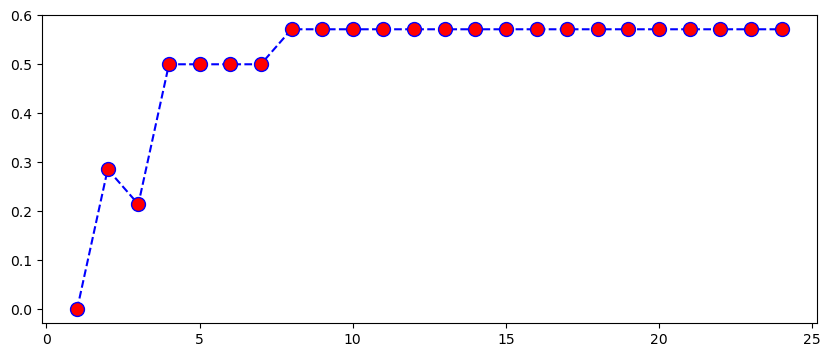

In [38]:
#iterate model using recall scores for class 1 as we would be more interested in capturing as many as possible 
#for the loan converted accounts

recall_scores = []

for max_d in range(1, 25):
    dtree = DecisionTreeClassifier(max_depth=max_d, random_state=42)
    dtree.fit(X_train, y_train)
    dtree_pred = dtree.predict(X_test)
    recall_scores.append(classification_report(y_test, dtree_pred, output_dict=True, zero_division=0)['1']['recall'])
    
plt.figure(figsize=(10, 4))
plt.plot(range(1, 25), recall_scores, ls='--', marker='o', color='blue', markerfacecolor='red', markersize=10)


index_range = range(1, 25)

data = {'Index': index_range, 'recall_scores': recall_scores}
df_test_recall = pd.DataFrame(data).set_index('Index')
df_test_recall.index.name = 'max_depth'
df_test_recall = df_test_recall.reset_index(drop=False)

df_test_recall = df_test_recall[(df_test_recall['recall_scores']==df_test_recall['recall_scores'].max())]
df_test_recall = df_test_recall[(df_test_recall['max_depth']==df_test_recall['max_depth'].min())]

df_test_recall

In [39]:
dtree = DecisionTreeClassifier(max_depth=8, random_state=42)

dtree.fit(X_train, y_train)
dtree_pred = dtree.predict(X_test)

print(classification_report(y_test, dtree_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       762
           1       0.67      0.57      0.62        14

    accuracy                           0.99       776
   macro avg       0.83      0.78      0.80       776
weighted avg       0.99      0.99      0.99       776



In [40]:
dtree_fi = pd.DataFrame(dtree.feature_importances_, X_test.columns, columns=['feature_importance'])
dtree_fi.sort_values(by='feature_importance', ascending=False)

,feature_importance
CCAvgSpending,0.282396
Income,0.150292
Age,0.120062
Deposit Account,0.115120
Family Size,0.112060
Education_Graduate,0.055519
Mortgage,0.036128
Education_Undergrad,0.034038
Experience,0.033618
Postal Code,0.030508


<b>CCAvgSpending</b> and <b>Income</b> appear to be the more important features

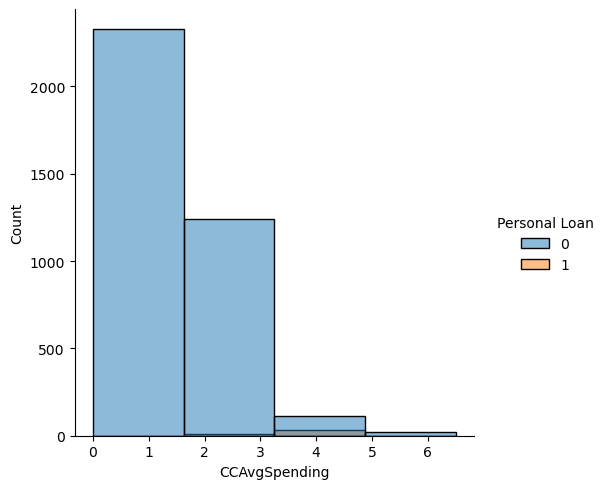

In [41]:
sns.displot(df[(df['Income']<100)], x='CCAvgSpending', hue='Personal Loan', bins=4)

All of the loan converted borrowers have avg. CC spending between 3-5k

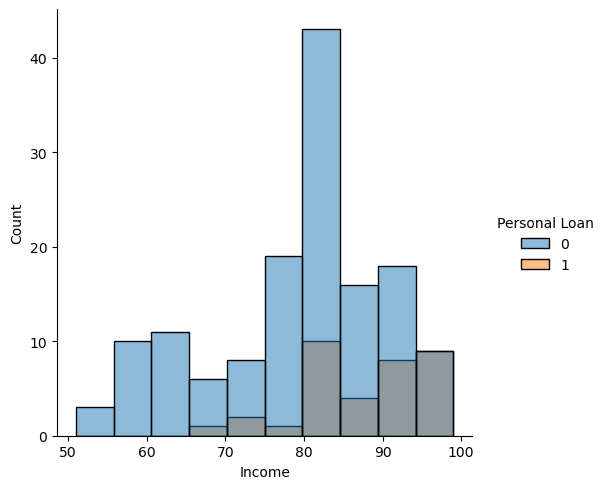

In [42]:
sns.displot(df[(df['Income']<100)&(df['CCAvgSpending']>3)&(df['CCAvgSpending']<5)], x='Income', hue='Personal Loan', bins=10)

higher concentration of personal loan borrower when income is at least 80k per year

In [43]:
success_rates = df[(df['Income']>80)&(df['Income']<110)&(df['CCAvgSpending']>3)&(df['CCAvgSpending']<5)]['Personal Loan'].mean().round(2)
campaign_scope = df[(df['Income']>80)&(df['Income']<110)&(df['CCAvgSpending']>3)&(df['CCAvgSpending']<5)].count()[0]
success_cnt = df[(df['Income']>80)&(df['Income']<110)&(df['CCAvgSpending']>3)&(df['CCAvgSpending']<5)&(df['Personal Loan']==1)].count()[0]


print('If we target individual with following traits')
print('1. Income between 80-110k')
print('2. CCAvgSpending between 3~5k')
print('\n')
print(f'We can expect to convert {success_cnt} out of total {campaign_scope}, success rates of {success_rates}.')

If we target individual with following traits
1. Income between 80-110k
2. CCAvgSpending between 3~5k


We can expect to convert 49 out of total 153, success rates of 0.32.


## Should we then plan a smaller scale campaign so as to not miss these 49 opportunities?

My general view is <b>not to recommend a seperate campaign targeting this smaller group</b>. This is because planning a <b>campaign can be resource intense</b>, and it's likely <b>not a smart use of resource</b> to just target this small group of individuals. 

However, this also <b>hinge on the overall growth strategy of the bank</b>, if current strategy for this product is <b>aggressive growth</b>, sometimes a company will be willing to aggressively campaign even if the unit of economics is negative. 

Other than aggressive growth, we might also be interested to campaign on this small group <b>if they belong to the young emerging wealth segment</b> : individual who might not be earning for now but has potential for exponetial growth later on. If this minor group belongs to be the emerging wealth segment, <b>it might be worthwhile to invest early to increase engagement</b> with them as they tend to <b>yield higher Lifetime Value (LTV)</b> later on as their income increase.

A quick way to check if these minor group has potential is to <b>check their age</b>

Average age is 47.0


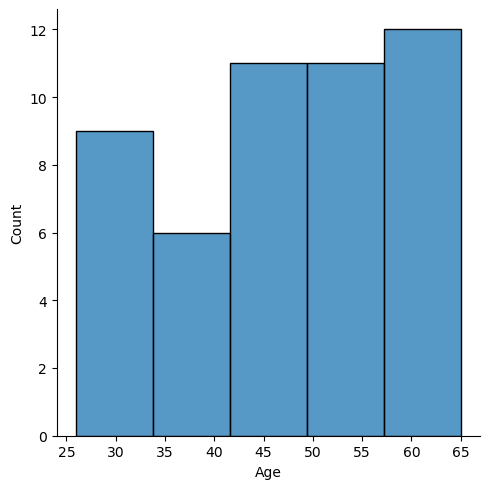

In [44]:
sns.displot(df[(df['Income']>80)&(df['Income']<110)&(df['CCAvgSpending']>3)&(df['CCAvgSpending']<5)&(df['Personal Loan']==1)]['Age'], bins=5)

avg_age = df[(df['Income']>80)&(df['Income']<110)&(df['CCAvgSpending']>3)&(df['CCAvgSpending']<5)&(df['Personal Loan']==1)]['Age'].mean().round(0)

print(f'Average age is {avg_age}')

So from the distribution plot and average age of 47, most borrowers in this minor group has limited income growth potential.